In [99]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('viridis')

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression


sns.set_style('darkgrid')
sns.set_palette('muted')
# sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# plt.rcParams.update({'font.size': 11,'figure.figsize': (20,10),'axes.titlesize':'large','axes.labelsize':'x-large','ytick.labelsize':20})


In [100]:
Quarterly = pd.read_csv("SP_Quarterly.csv").iloc[::-1]

In [101]:
Quarterly

,DATE,OPERATING_EARNINGS_PER_SHARE,AS_REPORTED_EARNINGS_PER_SHARE,CASH_DIVIDENDS_PER_SHARE,SALES_PER_SHARE,BOOK_VAL_PER_SHARE,CAPEX_PER_SHARE,PRICE,DIVISOR
132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,31/03/1988,$5.48,$5.53,$2.24,NaN,NaN,NaN,258.89,6977.40
130,30/06/1988,$6.05,$6.22,$2.50,NaN,NaN,NaN,273.50,6956.73
129,30/09/1988,$6.22,$6.38,$2.46,NaN,NaN,NaN,271.91,6930.89
128,31/12/1988,$6.37,$5.62,$2.54,NaN,NaN,NaN,277.72,6829.56
...,...,...,...,...,...,...,...,...,...
4,31/12/2019,$39.18,$35.53,$15.21,$369.23,$914.49,$23.23,"3,230.78",8282.73
3,31/03/2020,$19.50,$11.88,$15.32,$332.59,$885.59,$19.82,"2,584.59",8289.27
2,30/06/2020,$26.79,$17.83,$14.35,$315.61,$901.97,$17.17,"3,100.29",8269.11
1,30/09/2020,$37.90,$32.98,$13.97,$346.71,$920.34,$17.94,"3,363.00",8286.67


## Data tidying
We're going to be using the price and cash_dividends columns so we're going to need to drop null values for those columns. we also need to change the prices to numeric values, and it might help to have the dates as datetime objects

In [102]:
currency_cols = ['OPERATING_EARNINGS_PER_SHARE',
       'AS_REPORTED_EARNINGS_PER_SHARE', 'CASH_DIVIDENDS_PER_SHARE',
       'SALES_PER_SHARE', 'BOOK_VAL_PER_SHARE', 'CAPEX_PER_SHARE']

for col in currency_cols:
    Quarterly[col] = Quarterly[col].apply(lambda e: eval(str(e)[2:].strip(" ")) if str(e)[1] == '$' else e)
    
Quarterly.dropna(subset=['CASH_DIVIDENDS_PER_SHARE'],inplace = True)   
Quarterly.PRICE = Quarterly.PRICE.apply(lambda e: eval("".join(str(e).split(","))))
Quarterly.DIVISOR = pd.to_numeric(Quarterly.DIVISOR)



# CONVERTS DATE STRING TO DATETIME OBJECT
def to_dt_obj(date):
    dmy = list(map(lambda x: int(x),date.split('/')))
    return datetime(dmy[2],dmy[1],dmy[0])


Quarterly.DATE = Quarterly.DATE.apply(lambda date: to_dt_obj(date))


we can check the data types to see if theyre how we want them

In [103]:
Quarterly.dtypes

DATE                              datetime64[ns]
OPERATING_EARNINGS_PER_SHARE             float64
AS_REPORTED_EARNINGS_PER_SHARE           float64
CASH_DIVIDENDS_PER_SHARE                 float64
SALES_PER_SHARE                          float64
BOOK_VAL_PER_SHARE                       float64
CAPEX_PER_SHARE                          float64
PRICE                                    float64
DIVISOR                                  float64
dtype: object

## Approximate Dividend Growth

In [104]:
def range_slider(fig,buttons = None):
    if not buttons:
        buttons = [
                dict(count=7,
                     label="1w",
                     step="day",
                     stepmode="todate"),
                dict(count=14,
                     label="2w",
                     step="day",
                     stepmode="todate"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ]
    fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(buttons)
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ))
    
buttons = [
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
    
                dict(step="all")
            ]

In [105]:
Quarterly["CASH_DIVIDENDS_PER_SHARE"] = Quarterly.CASH_DIVIDENDS_PER_SHARE.rolling(window=4).sum()
Quarterly["5_yr_rolling_divs"] = Quarterly.CASH_DIVIDENDS_PER_SHARE.rolling(window=20).mean()

In [106]:
Quarterly.dropna(subset=["CASH_DIVIDENDS_PER_SHARE"],inplace = True)
plot = px.line(Quarterly,x = 'DATE', y = ["CASH_DIVIDENDS_PER_SHARE","5_yr_rolling_divs"],
              labels={
                         "value": "Divident per share ($)"
                     },
              title="Variation in S&P 500 Dividends since 1988")
range_slider(plot,buttons)
plot.show()

Approximating the divident growth is difficult. Suppose we approximated the slope begining in 2010. We'd get a different result than if we started in 1990. The problem here is working out whether something fundamentally changed in 2007 which altered the rate of divident growth, or whether this is just a deviation that will converge back to a constant historic mean. We also see a substantial slump at the very top of the curve in 2020. If we're valuing the market now, and we care more about more immediate rewards (the time value of money), then maybe we should pay more attention to current trends.

### Predicting Dividend Growth

We can use a polynomial regressor to try and predict the growth of the S&P

In [107]:
date = np.array(Quarterly.DATE.astype(int)).reshape(-1,1)

degree=3
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(date,Quarterly.CASH_DIVIDENDS_PER_SHARE)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [108]:
Quarterly['POLY_REG_DIVS'] = polyreg.predict(date)

In [109]:
plot = px.line(Quarterly,x = 'DATE', y = ["CASH_DIVIDENDS_PER_SHARE","5_yr_rolling_divs",'POLY_REG_DIVS'],
              labels={
                         "value": "Dividend per share ($)"
                     },
              title="Variation in S&P 500 Dividends since 1988")
range_slider(plot,buttons)
plot.show()

Our model outputs the green line in the above plot, which is an okay fit. We can now use our Polynomial regression model to predict dividends (and thus growth) for the next five years.

In [110]:
future_dates = list(map(lambda year : datetime(year,1,1), range(2020,2026)))
future_dates_formatted = np.array(pd.Series(future_dates).astype(int)).reshape(-1,1)

future_payouts = polyreg.predict(future_dates_formatted)

dividend_growth = []

for idx_prev,pay in enumerate(future_payouts[1:]):
    dividend_growth.append(pay/future_payouts[idx_prev] -1)
    
div_growth = pd.DataFrame({"Year":range(2021,2026),"Predicted Dividend Growth":dividend_growth}).set_index('Year').T
div_growth

Year,2021,2022,2023,2024,2025
Predicted Dividend Growth,0.054554,0.053655,0.052918,0.05219,0.051615


From our models predictions, we can see the growth rate seems to be decreasing.

## The DDM Model
The Formula for asset price, as given by the DDM model is the following:
>![\Medium P_1=\frac{D_1}{r-g}](https://latex.codecogs.com/svg.latex?\Large&space;P_1=\frac{D_1}{r-g}) 

Where P is the price, D_1 is the next Dividend payment, r is the COE/ROR, and g is the growth rate. As we know the growth rate, we can also say

>![\Medium P_1=\frac{D_0(1+g)}{r-g}](https://latex.codecogs.com/svg.latex?\Large&space;P_1=\frac{D_0(1+g)}{r-g}) 

Where D_0 is the current divident payment.

#### Obtaining the ROE

In [111]:
start = datetime(2020, 2, 1)
end = datetime(2021, 2, 1) 
SP500 = web.DataReader(['sp500'], 'fred', start, end)
#Drop all Not a number values using drop method.
SP500.dropna(inplace = True)
SP500ROR = (SP500['sp500'].iloc[-1]/ SP500['sp500'].iloc[0])-1
print("YEARLY ROE FOR THE S&P500: {}".format(SP500ROR))

YEARLY ROE FOR THE S&P500: 0.1615736921807862


#### Implementing the DDM
As from our quarterly data, we know the last known dividend sum was $14.64. setting this equal to `D_0` we can now implement the DDM

In [112]:
D_0 = 14.64
g = np.mean(dividend_growth)

r = 0.059
P_1 = D_0*(1+g)/(r-g)

P_1

2563.531928805038

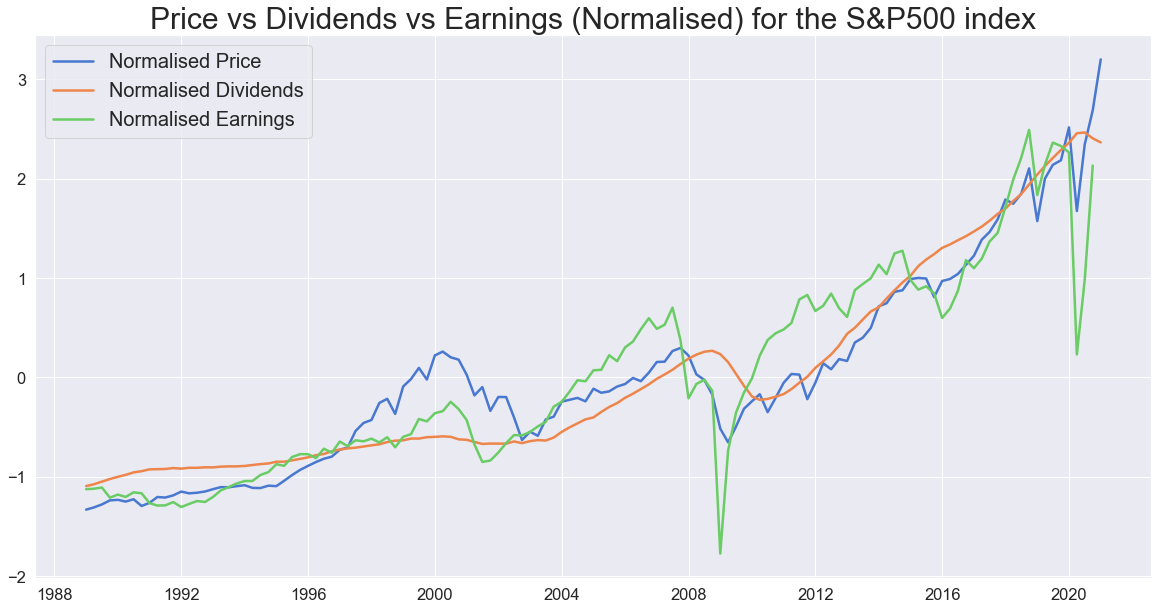

In [208]:
start = datetime(1990, 1, 15)
end = datetime(2021, 2, 15) 
SP500 = web.DataReader(['sp500'], 'fred', start, end)

P_mean =Quarterly.PRICE.mean()
P_std = Quarterly.PRICE.std()

D_mean = Quarterly.CASH_DIVIDENDS_PER_SHARE.mean()
D_std = Quarterly.CASH_DIVIDENDS_PER_SHARE.std()

E_mean = Quarterly.OPERATING_EARNINGS_PER_SHARE.mean() 
E_std = Quarterly.OPERATING_EARNINGS_PER_SHARE.std() 

plt.plot(Quarterly.DATE,Quarterly.PRICE.apply(lambda x: (x-P_mean)/P_std))
plt.plot(Quarterly.DATE,Quarterly.CASH_DIVIDENDS_PER_SHARE.apply(lambda x: (x-D_mean)/D_std))
plt.plot(Quarterly.DATE,Quarterly.OPERATING_EARNINGS_PER_SHARE.apply(lambda x: (x-E_mean)/E_std))
plt.legend(['Normalised Price','Normalised Dividends','Normalised Earnings'],fontsize = 20)
plt.title('Price vs Dividends vs Earnings (Normalised) for the S&P500 index',fontsize = 30)
plt.show()

In [209]:
Quarterly['Normalised Price'] = Quarterly.PRICE.apply(lambda x: (x-P_mean)/P_std)
Quarterly['Normalised Dividends'] = Quarterly.CASH_DIVIDENDS_PER_SHARE.apply(lambda x: (x-D_mean)/D_std)
Quarterly['Normalised Earnings'] = Quarterly.OPERATING_EARNINGS_PER_SHARE.apply(lambda x: (x-E_mean)/E_std)

In [210]:
plot = px.line(Quarterly,x = 'DATE', y = ['Normalised Price','Normalised Dividends','Normalised Earnings'],
              labels={
                         "value": "Normed Value"
                     },
              title='Price vs Dividends vs Earnings (Normalised) for the S&P500 index')
range_slider(plot,buttons)
plot.show()

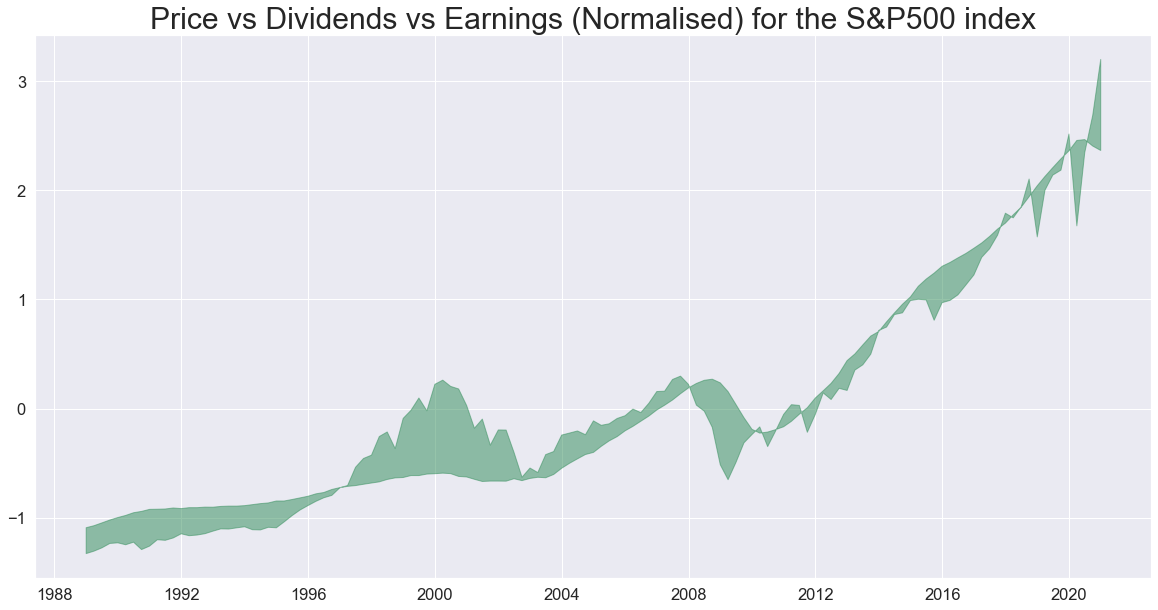

In [211]:

divs_normed = Quarterly.CASH_DIVIDENDS_PER_SHARE.apply(lambda x: (x-D_mean)/D_std)
price_normed = Quarterly.PRICE.apply(lambda x: (x-P_mean)/P_std)
my_color=np.where(np.array(price_normed)-np.array(divs_normed)>=0, 'red','seagreen')


plt.fill_between(Quarterly.DATE,divs_normed,price_normed,alpha = 0.5,color = my_color)

plt.title('Price vs Dividends vs Earnings (Normalised) for the S&P500 index',fontsize = 30)
plt.show()

Text(0.5, 1.0, 'Price vs Dividends (Normalised) for the S&P500 index')

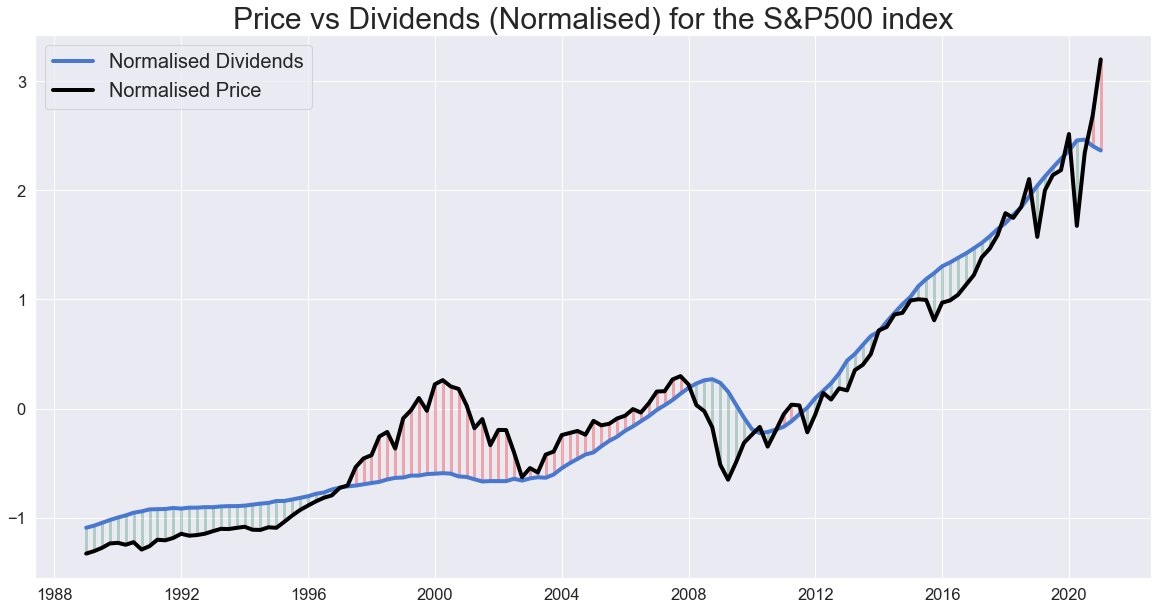

In [212]:

plt.plot(Quarterly.DATE,Quarterly.CASH_DIVIDENDS_PER_SHARE.apply(lambda x: (x-D_mean)/D_std),linewidth = 4)
plt.plot(Quarterly.DATE,Quarterly.PRICE.apply(lambda x: (x-P_mean)/P_std),alpha = 1,color = 'black',linewidth = 4)

plt.vlines(x=Quarterly.DATE,ymin=price_normed,ymax=divs_normed, color=my_color, alpha=0.3,linewidth=3)
plt.legend(['Normalised Dividends','Normalised Price'],fontsize = 20)
plt.title('Price vs Dividends (Normalised) for the S&P500 index',fontsize = 30)


/Users/Ali/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in greater_equal



Text(0.5, 1.0, 'Price vs Earnings (Normalised) for the S&P500 index')

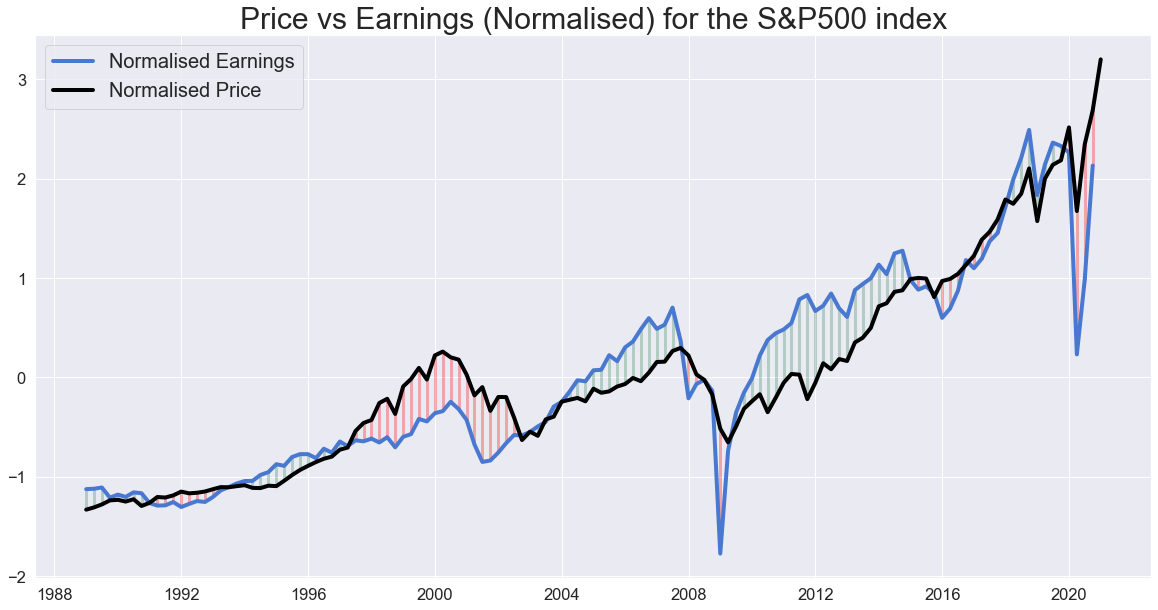

In [213]:


earnings_normed = Quarterly.OPERATING_EARNINGS_PER_SHARE.apply(lambda x: (x-E_mean)/E_std)





mi_color=np.where(np.array(price_normed)-np.array(earnings_normed)>=0, 'red','seagreen')



plt.plot(Quarterly.DATE,Quarterly.OPERATING_EARNINGS_PER_SHARE.apply(lambda x: (x-E_mean)/E_std),linewidth = 4)

plt.plot(Quarterly.DATE,Quarterly.PRICE.apply(lambda x: (x-P_mean)/P_std),alpha = 1,color = 'black',linewidth = 4)


plt.vlines(x=Quarterly.DATE,ymin=price_normed,ymax=earnings_normed, color=mi_color, alpha=0.3,linewidth=3)
plt.legend(['Normalised Earnings','Normalised Price'],fontsize = 20)
plt.title('Price vs Earnings (Normalised) for the S&P500 index',fontsize = 30)

/Users/Ali/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in greater_equal



Text(0.5, 1.0, 'Price vs Earnings+Dividends (Normalised) for the S&P500 index')

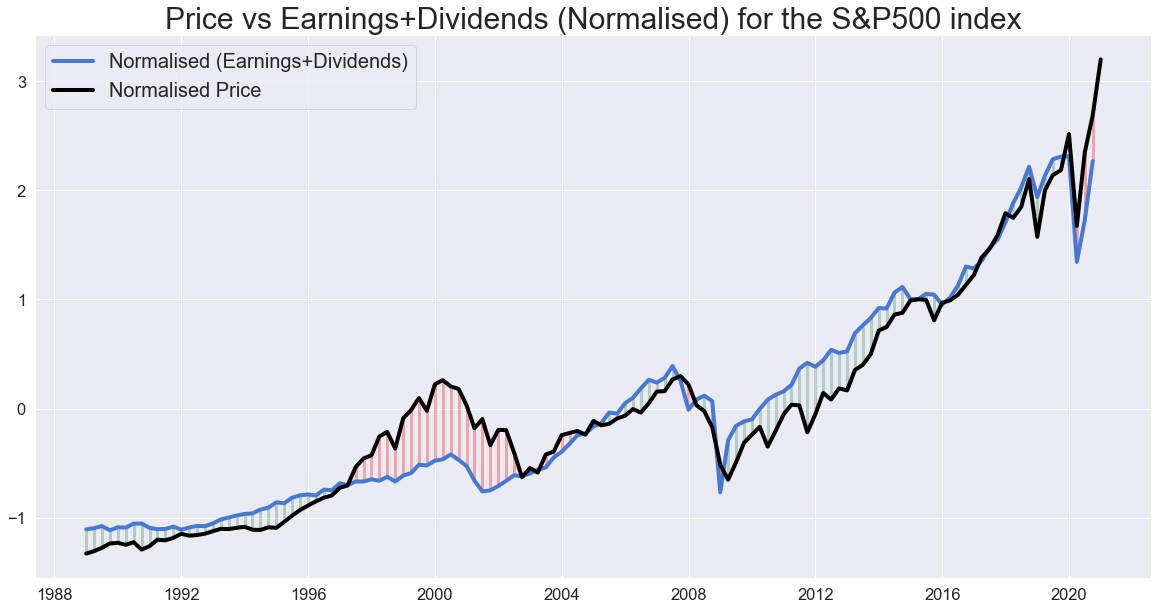

In [218]:




DEHybrid = (np.array(earnings_normed)+np.array(divs_normed))/2





mi_color=np.where(np.array(price_normed)-DEHybrid>=0, 'red','seagreen')



plt.plot(Quarterly.DATE,DEHybrid,linewidth = 4)

plt.plot(Quarterly.DATE,Quarterly.PRICE.apply(lambda x: (x-P_mean)/P_std),alpha = 1,color = 'black',linewidth = 4)


plt.vlines(x=Quarterly.DATE,ymin=price_normed,ymax=DEHybrid, color=mi_color, alpha=0.3,linewidth=3)
plt.legend(['Normalised (Earnings+Dividends)','Normalised Price'],fontsize = 20)
plt.title('Price vs Earnings+Dividends (Normalised) for the S&P500 index',fontsize = 30)